## Introduction

For this project I will be analysing punting and field goal data for the Canadian Football League with the aim of determining some insights about the kicking game. One particular interest is the effect of kicking indoors, in the CFL there is one indoor stadium. Having no adverse elements such as wind or rain or in the latter parts of the year, snow, indoor stadiums could potentially have a positive effect on the production and effectiveness of the kickers. Using data gathered from the CFL website containing stats of several years worth of kicking data I plan to investigate this to see if there is a significant difference in the productivity of the kicking game indoors vs outdoors. There are three types of kicking in the CFL for which stats are available: kick offs, punts, and field goals. The two I am most interested in are field goals and punting as they would be most affected by adverse conditions. I will first just look at general averages in each stadium to see if there are any differences but being that different players have different abilities, I believe it would make sense to analyse the data based on individual kicker’s performance both indoors and outdoors. It may also be that from year to year a kicker’s ability may change so in order to analyse the data each data point will be a kicker’s performance for each season played. Possible ways to extend this analysis is to look at which stadiums have the best and worst performance results. When it comes to punting, sometimes very windy stadiums can actually work in the favour of the punter as this can make it difficult for the returner to successfully catch the ball in the air.




## Data Details

The data obtained for this analysis is obtained directly from the cfl.ca website where statistics are for the public to view. The data was obtained using web scraping the data directly from the site in the form of a json document. The website gives the user the ability to set parameters for the statistics that they want including the what years, where the games were played, who the opponent was, and filtering the data by game, season, or player. Knowing how the url is constructed based on these parameters and filters, I built a function to download the datasets I was looking for and would save those datasets immediately to limit the need to re-download the datasets any more than necessary. While the data is public, ethically it is important to not download the data any more times than needed to reduce costs for the hosts of the data as these stats are not designed for high data usage downloading. These stats are for general browsing to fans of the league. The data obtained was for the four seasons from 2016 to 2019.

One challenge in the data acquiring process is that the downloaded data did not actually contain the stadium location data in the results. However the website allowed you to query the stats to limit the results based on the location of the games. My approach was to create a function to download a dataset for each stadium location and put this into a list. Once in the list I then could append the location to the dataset downloaded and then combine all the datasets for each location, with the data of the location included, into a final complete dataset.
The dataset had a lot of other categories not needed so they were removed as well as both the punt average and field goal percentage needed to be converted to a float from an object . 

The punting dataset contains the year, punter’s name, the location, the number of punts, total punt yards, and punt average. The field goal dataset contains the year, kicker’s name, field goals attempted, field goals made, accuracy, a breakdown of distances of the field goals made distances, and converts made and attempted. Converts are a special field goal that is attempted after a touchdown that is a specific distance. These are only worth one point so are kept as a separate statistic. 


In [1]:
from bs4 import BeautifulSoup
import requests
import json
import pandas as pd 
import numpy as np

In [2]:
# list of all the team location acronyms for data retrieval
team_codes = ['bc', 'edm', 'cgy', 'ssk', 'wpg', 'ham', 'tor', 'ott', 'mtl']


For each team code create the url to retrieve the appropriate data set.  
This is equal to the `base url + filter location = team code`  
If the `include_home` parameter is set to `True`, results will include the home kicker for each location as well.  
The `kick_category` parameter is to set whether to rertieve punting or field goal data. 

In [725]:
def get_game_data(team_codes, kick_category, include_home):
    # if category is punting - add a filter so that a minumum of 1 punts is returned
    # otherwise CFL returns a dataset including every player on the roster for the game instead of just the players who had a punt
    # same issue doesn't exist for field goals so this filter not needed
    if kick_category == 'punting':
        base_url = 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=punting&filter[season][ge]=2016&filter[punts][ge]=1&filter[location][eq]='
    else:
        base_url = 'https://www.cfl.ca/wp-content/themes/cfl.ca/inc/admin-ajax.php?action=get_league_stats&stat_category=field_goals&filter[season][ge]=2016&filter[location][eq]='
    json_data = []
    for team in team_codes:
        if include_home: 
            url = base_url + team + '&group_by=player'
        else:
            # if only want to include players away games (no home advantage)
            # set filter so that opposing team = team location so home player data not included
            url = base_url + team + '&filter[opponent_team_abbreviation][eq]=' + team + '&group_by=player'
        site_json = get_site_json(url)
        json_data.append(site_json)
    return json_data

## Download all the datasets

In [726]:
home_game_data_punt = get_game_data(team_codes, 'punting', True)

In [727]:
home_game_data_fg = get_game_data(team_codes, 'field_goals', True)

In [728]:
away_game_data_punt = get_game_data(team_codes, 'punting', False)

In [729]:
away_game_data_fg = get_game_data(team_codes, 'field_goals', False)

## Save Retrieved Data to file

In [775]:
def save_json_to_file(data, name):
    with open(name, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=3)

save_json_to_file(home_game_data_punt, 'home_game_data_punt.json')
save_json_to_file(away_game_data_punt, 'away_game_data_punt.json')
save_json_to_file(home_game_data_fg, 'home_game_data_fg.json')
save_json_to_file(away_game_data_fg, 'away_game_data_fg.json')

## Create DataFrames and add Locations to the datasets
### The downloaded data is able to be filtered by location but doesn't include the location in the data itself

In [5]:
def getDFFromJson(data):
    df = pd.DataFrame(data['data'])
    return df


# Column headers for punt df and field goal df
punt_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG', 'PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S']
fg_columns = ['YEAR', 'NAME', 'LOCATION', 'URL', 'TEAM', 'GAMES_PLAYED', 'FG_ATTEMPTS', 'FG_MADE', 'ACCURACY', 'LONG', 'S', 'lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']


def createDFwLocationFromFile(file_name, team_codes, column_names):
    #check if length of data = length of team_codes
    with open(file_name) as f:
        data = json.load(f)
    if(len(data) == len(team_codes)):
        print('length equal')
        # empty array to put each stadium dfs in
        dn = []
        for i, team in enumerate(team_codes):
            #create df from data[i]
            df = getDFFromJson(data[i])
            #add location of game to df
            df.insert(2, 'LOCATION', team)
            #add df to df list
            dn.append(df)
        # create new df with all location dfs combined
        dn = pd.concat(dn, axis=0, )
        # add column names to df
        
        dn.columns = column_names
        return dn
    else:
        print('not equal')


In [6]:
df_away_punt = createDFwLocationFromFile('away_game_data_punt.json', team_codes, punt_columns)
df_home_punt = createDFwLocationFromFile('home_game_data_punt.json', team_codes, punt_columns)
df_away_fg = createDFwLocationFromFile('away_game_data_fg.json', team_codes, fg_columns)
df_home_fg = createDFwLocationFromFile('home_game_data_fg.json', team_codes, fg_columns)

length equal
length equal
length equal
length equal


In [8]:
# Check dataframe to make sure structure is correct with location added
df_away_punt.head()

,YEAR,NAME,LOCATION,URL,TEAM,GAMES_PLAYED,NUMBER_OF_PUNTS,PUNT_YDS,PUNT_AVG,PUNT_LONG,PUNT_SINGLES,NUMBER_OF_KICKOFFS,KO_YDS,KO_AVG,KO_LG,KO_S
0,2018,"O'NEILL, Hugh",bc,https://www.cfl.ca/players/hugh-o-neill/158179/,EDM,2,15,665,44.3,51,0,10,625,62.5,68,0
1,2016,"MAVER, Rob",bc,https://www.cfl.ca/players/rob-maver/157429/,CGY,2,11,499,45.4,56,0,0,0,0.0,0,0
2,2019,"LEONE, Richie",bc,https://www.cfl.ca/players/richie-leone/161073/,OTT,1,9,429,47.7,60,0,1,65,65.0,65,0
3,2019,"RYAN, Jonathan",bc,https://www.cfl.ca/players/jonathan-ryan/111244/,SSK,2,8,396,49.5,72,1,0,0,0.0,0,0
4,2017,"O'NEILL, Hugh",bc,https://www.cfl.ca/players/hugh-o-neill/158179/,EDM,1,8,382,47.8,56,0,6,366,61.0,63,0


## Clean up the DataFrames retrieved
### Remove unused columns and fix some formatting

In [9]:
def clean_df_punt(df):
    #filter out any rows with punts < 2
    #remove Kickoff columns and other columns not of interest
    df = df[df.NUMBER_OF_PUNTS.gt(1)].drop(['URL', 'TEAM', 'GAMES_PLAYED','PUNT_LONG', 'PUNT_SINGLES', 'NUMBER_OF_KICKOFFS', 'KO_YDS', 'KO_AVG', 'KO_LG', 'KO_S'], axis=1)

    #sort values
    df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
    df['LOCATION'] = df['LOCATION'].str.upper()

    #convert PUNT_AVG type from object to float
    df['PUNT_AVG'] = df['PUNT_AVG'].astype(float, errors = 'raise')
    return df

df_away_punt_clean = clean_df_punt(df_away_punt)
df_home_punt_clean = clean_df_punt(df_home_punt)

In [10]:
def clean_df_fg(df):
    #remove any unused columns 
    df= df.drop(['URL', 'TEAM', 'S', 'GAMES_PLAYED', 'LONG', 'S'], axis=1)
    
    #sort values 
    df = df.sort_values(by=['LOCATION','NAME', 'YEAR'])
    df['LOCATION'] = df['LOCATION'].str.upper()

    df['ACCURACY'] = df['ACCURACY'].astype(float, errors = 'raise')
    return df

df_away_fg_clean = clean_df_fg(df_away_fg)
df_home_fg_clean = clean_df_fg(df_home_fg)

## Data Limitations

The limitations of the punt data is that punt average has limitations as a punting performance metric. The total punt yards per punt is calculated from the line of scrimmage where the play starts to where the ball is caught or picked up by the returner. If the ball lands on the ground at 30 yards which is a poor punt, and gets a lucky bounce and goes an extra 30 yards, this would be recorded as a 60 yard punt or a very good punt if it was kicked well. This is where a particularly windy game can possibly have favourable results for the punter’s statistics as the wind can make it very challenging for the returner to catch the ball in the air resulting in short punts that bounce past the returner for a long punt recorded in the statistics. 

The limitations of the field goal data is that field goal accuracy depends a lot on the distance of the attempt. Whereas with punts, generally the desired outcome is to kick the ball as far as possible each time and the chance of success is not determined by where the punter is on the field. The data obtained from the website categorizes the field goals that were made but does not show the distance that the field goals that were missed were kicked from. This makes it not possible to determine the accuracy from different ranges which would be a more useful statistic. Even in unfavourable weather conditions outdoors, a short range field goal will likely be made every time. The longer the field goal, the greater the chance for the kick to be affected by wind. 


In [12]:
def get_location_punt_averages(df):
    total_punts = df['NUMBER_OF_PUNTS'].groupby(df['LOCATION']).sum()
    total_punt_yards = df['PUNT_YDS'].groupby(df['LOCATION']).sum()
    averages =  (total_punt_yards / total_punts).round(1)
    df = pd.DataFrame(averages, columns=['PUNT_AVG'])
    df['LOCATION'] = df.index
    return df

def get_location_fg_accuracies(df):
    total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
    total_made = df['FG_MADE'].groupby(df['LOCATION']).sum()
    accuracies = (total_made / total_attempts * 100).round(1)
    df = pd.DataFrame(accuracies, columns=['ACCURACY'])
    df['LOCATION'] = df.index
    return df
    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean)
home_punt_avgs = get_location_punt_averages(df_home_punt_clean)

home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)

## Preliminary visualizations and data analyis 

Plot each as a boxplot with years seperate and years together

Boxplot is not a great way for fg % as there's an upper and lower limit (0 - 100) %

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

### Use boxplots showing each year and results by location

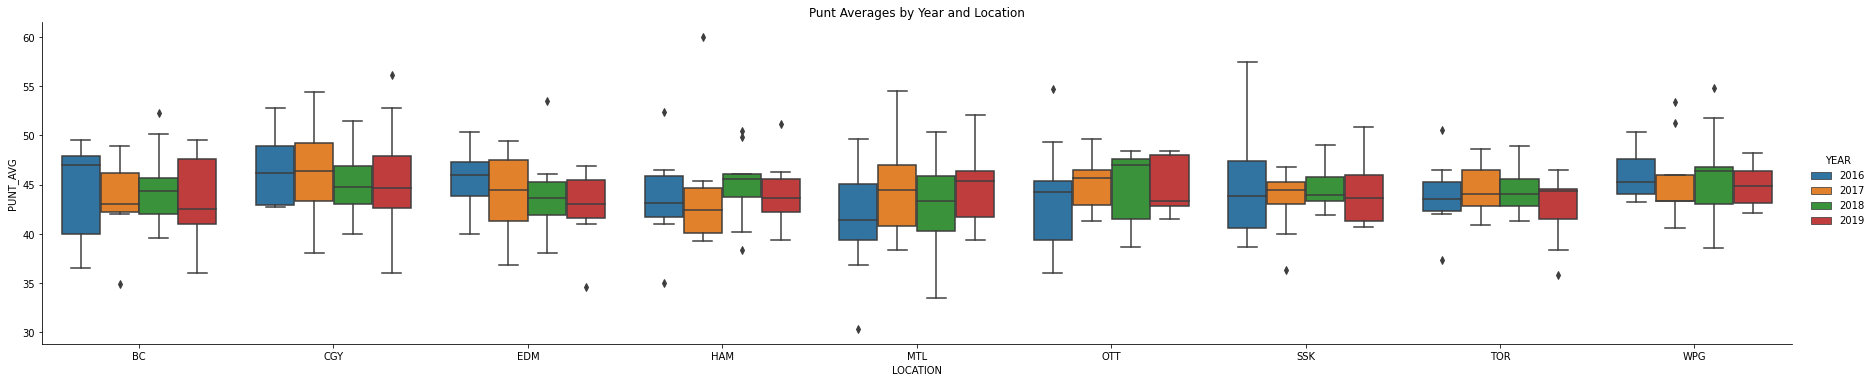

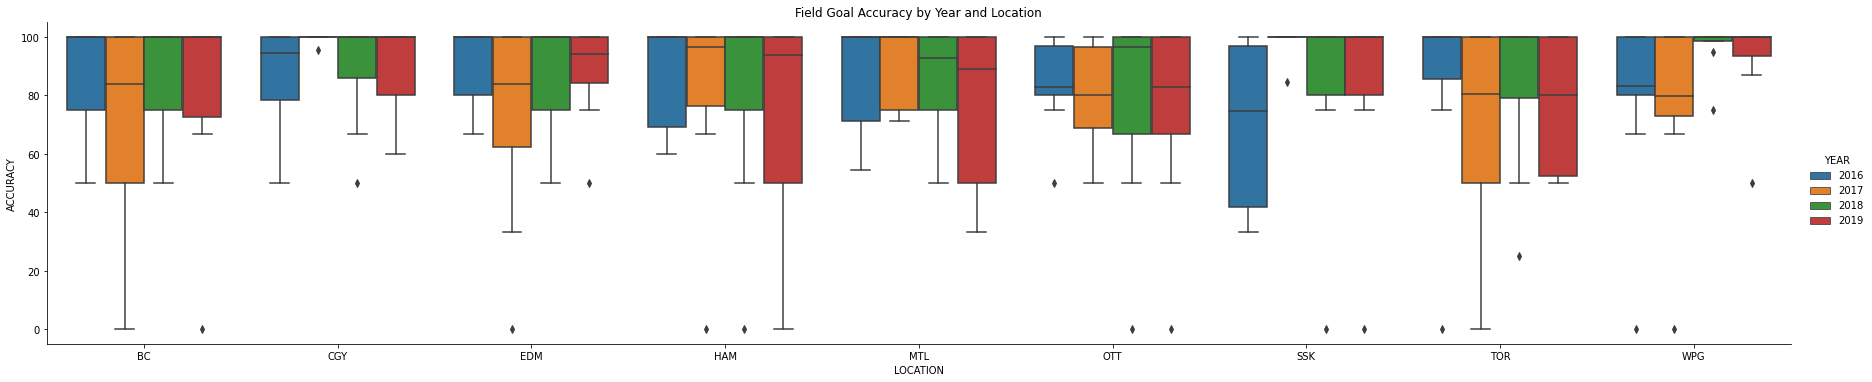

In [20]:
c = sns.catplot(x='LOCATION', y='PUNT_AVG', hue='YEAR', data=df_home_punt_clean, kind='box', aspect=5).set(title='Punt Averages by Year and Location')
d = sns.catplot(x='LOCATION', y='ACCURACY', hue='YEAR', data=df_home_fg_clean, kind='box', aspect=5).set(title='Field Goal Accuracy by Year and Location')


While seperating the seasons is useful for the individual data points, when plotted it does not provide a very clear picture as to what is happening so I will combine the data to just by location for all years into one boxplot. 

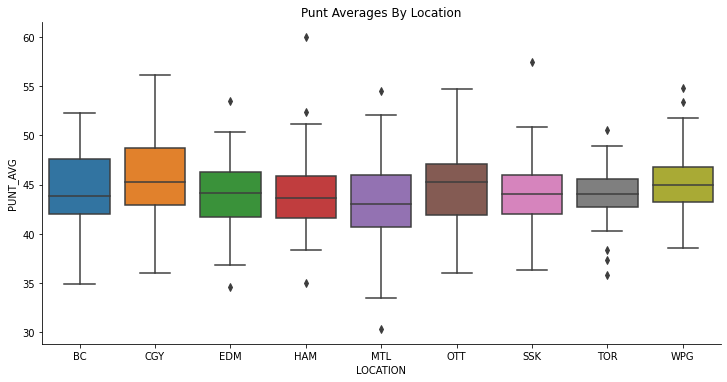

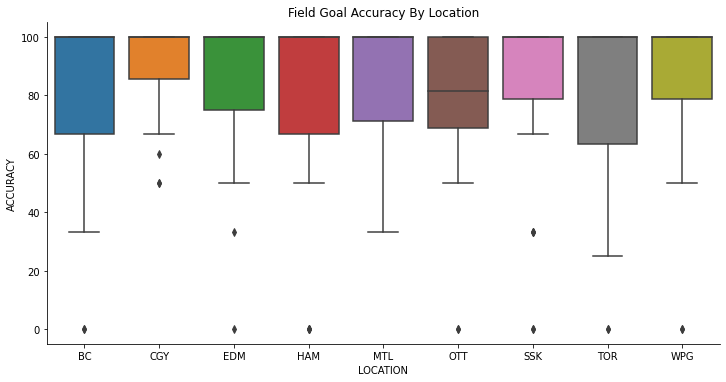

In [27]:
e = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_home_punt_clean, kind='box', aspect=2).set(title='Punt Averages By Location')
f = sns.catplot(x='LOCATION', y='ACCURACY', data=df_home_fg_clean, kind='box', aspect=2).set(title='Field Goal Accuracy By Location')



From these plots it looks that BC is slightly above average when it comes to punting with Calgary (CGY) and Ottawa (OTT) appearing to have the highest averages. The use of boxplots for field goal accuracy does not paint a very clear picture as many of the data points are 100% which is the cap for this data. Overall Calgary again seems to have the most concentrated data near 100% however while it is not apparent if BC is better or worse than the other stadiums. 

One issue I wanted to address with this type of data is that the home team kicker or punter statistics at their home would have a great weighting on that location’s results. They play at home 9 games a year, so their particular abilities could have the potential of skewing the results towards their individual ability. While only including visiting kickers visiting the stadium play once or twice a year at that particular location at most so their data would be more evenly weighted. To account for this I created a second dataset that excluded all kicks and punts from the home team kicker in their respective stadiums so that the results could be compared. 



### Get each location overall accuracy and overall punt average data 
#### This is done by aggregating all field goal and punt data

For field goals all field goal attempts are summed as well as all field goals made then accuracy is calculated from these results.  

With punts the total yards punted summed is divided by the total punts to get the overall avearage.  

If I was to just take the average of the accuracy and punt averages already calculated a one punt game of 70 yards would have the same weight as a 10 punt game with an average of 45 so it is important to do it this way or else that data would be inaccurate. 


In [786]:
def get_location_punt_averages(df):
    total_punts = df['NUMBER_OF_PUNTS'].groupby(df['LOCATION']).sum()
    total_punt_yards = df['PUNT_YDS'].groupby(df['LOCATION']).sum()
    averages =  (total_punt_yards / total_punts).round(1)
    df = pd.DataFrame(averages, columns=['PUNT_AVG'])
    df['LOCATION'] = df.index
    return df

def get_location_fg_accuracies(df):
    total_attempts = df['FG_ATTEMPTS'].groupby(df['LOCATION']).sum()
    total_made = df['FG_MADE'].groupby(df['LOCATION']).sum()
    accuracies = (total_made / total_attempts * 100).round(1)
    df = pd.DataFrame(accuracies, columns=['ACCURACY'])
    df['LOCATION'] = df.index
    return df
    
away_punt_avgs = get_location_punt_averages(df_away_punt_clean)
home_punt_avgs = get_location_punt_averages(df_home_punt_clean)
home_fg_accuracies = get_location_fg_accuracies(df_home_fg_clean)
away_fg_accuracies = get_location_fg_accuracies(df_away_fg_clean)

### Create a DataFrame with the aggregate punt averages and aggregate field goal accuracies

In [49]:
dn = [home_punt_avgs, away_punt_avgs, home_fg_accuracies, away_fg_accuracies]

dn = pd.concat(dn, axis=1)
dn = dn.drop(['LOCATION'], axis=1)
dn.columns = ['PUNT_AVG_HOME', 'PUNT_AVG_AWAY', 'FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY']

dn

,PUNT_AVG_HOME,PUNT_AVG_AWAY,FG_HOME_ACCURACY,FG_AWAY_ACCURACY
LOCATION,,,,
BC,45.8,44.0,85.1,83.8
CGY,45.9,45.8,89.9,89.6
EDM,43.9,43.6,86.4,81.9
HAM,44.4,43.6,83.1,81.0
MTL,44.0,43.9,82.1,84.0
OTT,45.6,45.0,83.3,81.2
SSK,44.9,44.2,84.9,88.3
TOR,44.6,44.1,81.0,80.9
WPG,45.0,45.5,87.2,88.1


### Plot home and away performances vs exclusively away games

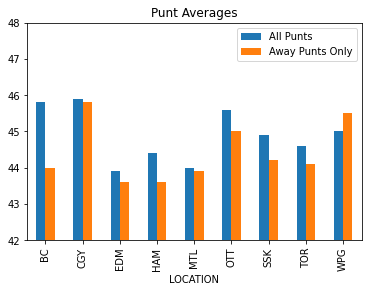

In [58]:
dn_loc = dn.copy()
dn_loc['LOCATION'] = dn.index

ax1 = dn_loc.plot.bar(x='LOCATION', y=['PUNT_AVG_HOME', 'PUNT_AVG_AWAY'], title='Punt Averages')
ax1.set_ylim(42, 48)
ax1.legend(labels=['All Punts', 'Away Punts Only'])


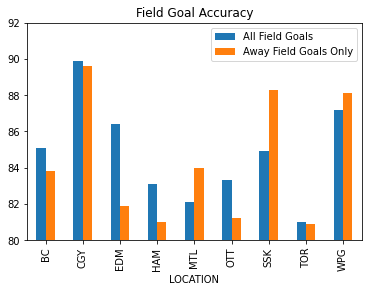

In [60]:
ax2 = dn_loc.plot.bar(x='LOCATION', y=['FG_HOME_ACCURACY', 'FG_AWAY_ACCURACY'], title='Field Goal Accuracy')
ax2.set_ylim(80, 92)
ax2.legend(labels=['All Field Goals', 'Away Field Goals Only'])

When we compare all games played to only including away games, the most notable difference in punting average is actually in BC where the home punters have significantly affected the average upwards. The average increase from 44.0 to 45.8 yards. Field goal accuracy shows a slight drop in accuarcy in BC when removing the home kickers performance. The most notable diffences are in Edmonton (EDM) where the home kickers boost the accuarcy from 81.9% to 86.4% but in Saskatchewan (SSK) the home kickers performances drops the accuarcy from 88.3% to 84.9%. This shows that including the home players performance in the results can have a large impact on the overall results so it makes sense to exclude them going forward or at least keep them seperate. Otherwise we may be interpreting results that are actually just the result of a particularly strong or weak player's performaces over a few seasons. 

## Normalize the Data and Visualize



In [86]:
# drop the columns that include the home players in the data
dn_away_only = dn.drop(['PUNT_AVG_HOME', 'FG_HOME_ACCURACY'], axis=1)
dn_away_only

,PUNT_AVG_AWAY,FG_AWAY_ACCURACY
LOCATION,,
BC,44.0,83.8
CGY,45.8,89.6
EDM,43.6,81.9
HAM,43.6,81.0
MTL,43.9,84.0
OTT,45.0,81.2
SSK,44.2,88.3
TOR,44.1,80.9
WPG,45.5,88.1


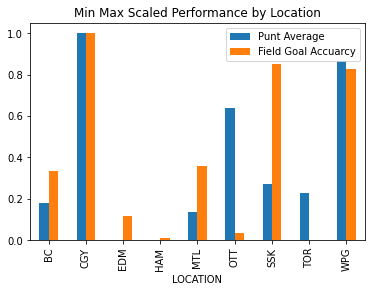

In [83]:
scaler = preprocessing.MinMaxScaler()
dn_scaled = pd.DataFrame(scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
# add location back 
dn_scaled['LOCATION'] = dn.index
ax3 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location')
ax3.legend(labels=['Punt Average', 'Field Goal Accuarcy'])


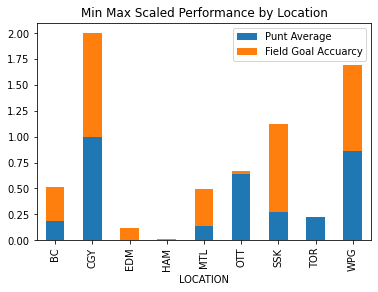

In [84]:
ax4 = dn_scaled.plot.bar(x='LOCATION', title='Min Max Scaled Performance by Location', stacked=True, sort_columns=True)
ax4.legend(labels=['Punt Average', 'Field Goal Accuarcy'])


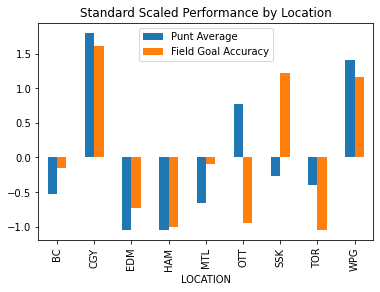

In [82]:
standard_scaler = preprocessing.StandardScaler()
dn_standard_scaled = pd.DataFrame(standard_scaler.fit_transform(dn_away_only), columns=dn_away_only.columns)
dn_standard_scaled['LOCATION'] = dn_away_only.index
ax5 = dn_standard_scaled.plot.bar(x='LOCATION', title='Standard Scaled Performance by Location')
ax5.legend(labels=['Punt Average', 'Field Goal Accuracy'])

When plotting this data after scaling, I found that using the min max scaler technique was useful for a stacked bar graph to show overall performance of each location. However I found that the standard scaler's ability to show negative values for performances that were below average also a useful visual for comparison across stadiums. In the first min max bar graph that is not stacked, it is difficult to see the lower performances, especially the wost performances such as in Hamilton and Toronto where there is no bar. This is why I like the standard scaled better. 

When looking at the data overall we can see that Calgary has the best performances in both punting and field goals and winnipeg is right behind. Saskatchewan has good field goal accuracy and Ottawa has good the next best punting average. The worst performing stadiums are Hamilton followed by Edmonton and Toronto. Toronto had the worst field goal accuarcy performance and Hamilton and Edmonton were tied for the worst overall punting average. 

## Compare Outdoor vs Indoor (BC) Data

In order to compare indoor vs outdoor data, I will add a column to each dataset that is the aggregate of all locations that outdoors or not BC. This will requiring aggregating all the data from the other locations, mainly field goal attempts and attempts made, then punt yards and numeber of punts. The location will be labeled as 'OUT'. 

In [87]:
## add outdoors column to datasets as they are

def add_outdoor_col_punt(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    df_bc = df[df['LOCATION'].eq('BC')]
    df = df[df['LOCATION'].ne('BC')]
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    for year in years:
        for player in players:
            num_punt_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'NUMBER_OF_PUNTS'].sum()
            punt_yard_sum = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'PUNT_YDS'].sum()
            if num_punt_sum > 0:
                out_ave = punt_yard_sum / num_punt_sum
                # temp_df = pd.DataFrame([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
                outdoor_data.append([year, player, 'OUT', num_punt_sum, punt_yard_sum, out_ave])
            else:
                continue
    column_names = list(df.columns)
    outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    df = df.append(outdoor_df)
    # add bc location data back to dataframe with outdoor data
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_punt_out = add_outdoor_col_punt(df_away_punt_clean)


In [88]:

def add_outdoor_col_fg(df1):
    #get data for each year and punter with location ne BC
    df = df1.copy()
    #get all data excluding BC data
    df_bc = df[df['LOCATION'].eq('BC')]
    # get list of players and years
    df = df[df['LOCATION'].ne('BC')]
    # get bc location data
    years = df.YEAR.unique()
    players = df.NAME.unique()
    outdoor_data=[]  
    # get column names for df
    column_names = list(df.columns)
    for year in years:
        for player in players:
            #get total attempst and made for each player in each year
            sum_fg_attempts = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_ATTEMPTS'].sum()
            sum_fg_made = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), 'FG_MADE'].sum()
            if sum_fg_attempts > 0:
                # calculate accuracy
                out_percentage = (sum_fg_made / sum_fg_attempts) * 100
                # get sums of the rest of numeric data
                details_data = df.loc[(df['YEAR'] == year) & (df['NAME'] == player ), ['lt_20', '20_29', '30_39', '40_49', 'gte_50', 'C1_ATT', 'C1_MADE']].sum()
                details_data = details_data.round()
                # create an empty df
                temp_df = pd.DataFrame([], columns=column_names)
                # add distance details to df
                temp_df = temp_df.append(details_data, ignore_index=True)
                # add player year location fg made and attempt data to df
                temp_df = temp_df.assign(YEAR=year, NAME=player, LOCATION='OUT', FG_ATTEMPTS=sum_fg_attempts, FG_MADE=sum_fg_made, ACCURACY=out_percentage)
                # add df to array
                outdoor_data.append(temp_df)                
            else:
                continue
    # outdoor_df = pd.DataFrame(outdoor_data, columns=column_names)
    dn = pd.concat(outdoor_data, axis=0, )
    df = df.append(dn)
    # add bc data back to dataframe
    df = df.append(df_bc)
    df = df.round(1)
    return df

df_away_fg_out = add_outdoor_col_fg(df_away_fg_clean)


## Create Visualizations Comparing BC and Outdoors

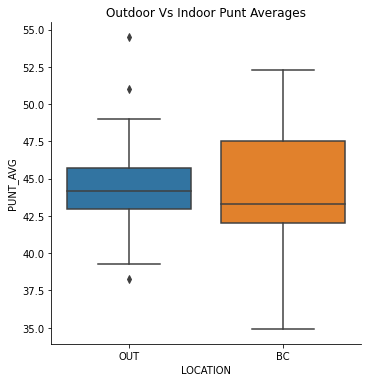

In [106]:
# create new dataframe that includes only the data for Outdoors and BC
df_away_punt_out_bc = df_away_punt_out[df_away_punt_out['LOCATION'].isin(['OUT','BC'])]
df_away_fg_out_bc = df_away_fg_out[df_away_fg_out['LOCATION'].isin(['OUT','BC'])]


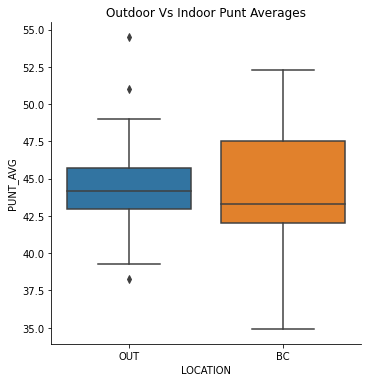

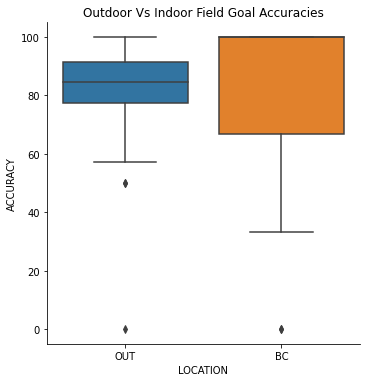

In [108]:

o = sns.catplot(x='LOCATION', y='PUNT_AVG', data=df_away_punt_out_bc, kind='box').set(title='Outdoor Vs Indoor Punt Averages')
p = sns.catplot(x='LOCATION', y='ACCURACY', data=df_away_fg_out_bc, kind='box').set(title='Outdoor Vs Indoor Field Goal Accuracies')

In [102]:
def get_overall_punt_avg(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_AVG'] = sum_df['PUNT_YDS'] / sum_df['NUMBER_OF_PUNTS'] 
    return sum_df['OVERALL_AVG'].round(1)
#BC average = 44.0
#Out average = 44.5
get_overall_punt_avg(df_away_punt_out_bc).round(2)

LOCATION
BC     44.0
OUT    44.5
Name: OVERALL_AVG, dtype: float64

In [113]:
def get_overall_fg_accuracy(df):
    sum_df = df.groupby('LOCATION').sum()
    sum_df['OVERALL_ACCURACY'] = sum_df['FG_MADE'] / sum_df['FG_ATTEMPTS']
    sum_df = sum_df.transform(lambda x: x*100)
    return sum_df['OVERALL_ACCURACY'].round(1)

get_overall_fg_accuracy(df_away_fg_out_bc)

LOCATION
BC     83.8
OUT    84.1
Name: OVERALL_ACCURACY, dtype: float64

# THOUGHTS ON STATE OF DATA AND WHAT TO DO

This data is just about averages and percentages, it does not weight those based on attempts and kicks  
What I need to do is aggregate the number of punts and total yards to get the average and for fg aggregate the total attempts and total makes instead of just doing the percentages
a 1/1 game or an 0/1 game has just as much weight as a 5/5 game by just going by percentages

However if looking at individual punters - then need to figure out their difference in punting / fg success in each stadium

Need to reduce effect of outliers like medlocks's 2 punts for 120 yards in hamilton game

How to account for the difficulty of the fg's attempted? Can't at this point as the data only shows fg's made from each distance, doesn't show attempts from each distance which is dumb!

Comparing data by player and whether they performed better or worse outdoors or indoors

In [819]:
df1 = df_away_games_only.copy()
df2 = df_home_and_away_games.copy()
# find where year and name are the same - get all rows
# take those and then based on location, put the vaules into appropriate columns
df_home_away_pivot = pd.pivot_table(df2, values=['NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)
df_away_only_pivot = pd.pivot_table(df1, values=['NUMBER_OF_PUNTS', 'PUNT_YDS', 'PUNT_AVG'], index=['YEAR', 'NAME'], columns=['LOCATION'], fill_value=0)

df_away_only_pivot


NUMBER_OF_PUNTS                                  \
LOCATION                                 BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                     
2017 ALLEN, Kenneth                       0   0   0   0   5   7   0   0   0   
     BARTEL, Josh                         7  17   6   9   6   8   0   5   7   
     BEDE, Boris                          5   7   5   0   0   4   0  17   4   
     CASTILLO, Sergio                     6  11   4   0   0   7   4   6   0   
     FAUBERT-LUSSIER, Felix               0   0   0   0   0   0   0   0   4   
     HAJRULLAHU, Lirim                    2  11   4  13   5   9   5   0   4   
     LANKFORD, Ryan                       0   0   0   0   2   0   0   0   0   
     LONG, Ty                             0   7   5   4   8   6   8   8  15   
     MAHER, Brett                         8   4   8   5   7   0   5   6  11   
     MAVER, Rob                           7   0  14   6   6   7   5   4   6   
     MEDLOCK, Justin                      8   6   7   2   4   3  14   3   0   
     O'NEILL, Hugh                        8   4   0   0   5   5   5   7   4   
     RUSSOLINO, Taylor                    0   0   0  10   0   0   9   0   0   
     WHYTE, Sean                          8   0   0   7   0   0   0   0   0   
2018 BARTEL, Josh                         8   3   9   5   4   7   0   4  19   
     BEDE, Boris                          9   7   7   7   0  14  10   4   8   
     HAJRULLAHU, Lirim                    8   8   4   0   2   5   6  11   5   
     LANKFORD, Ryan                       0   0   6   0   0   0   0   0   0   
     LEONE, Richie                        7   8   6  12   9   0   9   8   6   
     LONG, Ty                             0  10   5   8   6   7   8   5   8   
     MAVER, Rob                           6   0   2   7   9   9  14   2   7   
     MEDEIROS, Zackary                    6   7   0   6   7   4   0   0   0   
     MEDLOCK, Justin                      4   9   5   7   2   3   5   7   0   
     O'NEILL, Hugh                       15   6   0  10   3   5   5   4   7   
     PFEFFER, Ronald                      0   0   7   0  10   0  10   0   5   
2019 BARTEL, Josh                         0   0   9   5   5   3   3   0   3   
     BEDE, Boris                          6   7   4   8   0   8   6   8   5   
     CASTILLO, Sergio                     0   4   3   0   0   0   0   9   0   
     HAJRULLAHU, Lirim                    7   3   7   0  10   9   8   3   7   
     LEONE, Richie                        9   7   7   9   8   0   6  16  12   
     MAVER, Rob                           8   0   4   7   5   2   4   7  14   
     MEDEIROS, Zackary                    0   7  10   0   0   0   9   0  10   
     MEDLOCK, Justin                      6   3   5   8   4   6  14   7   0   
     O'NEILL, Hugh                        5   9   0   8   5  11   6   0   7   
     PFEFFER, Ronald                      7   0   0  16   6   5   0   0   0   
     RYAN, Jonathan                       8   4   7   8   7   7   0   4   7   
     WHYTE, Sean                          0   6   0   0   0   0   0   4   0   

                            PUNT_AVG  ...       PUNT_YDS                      \
LOCATION                          BC  ...   WPG       BC  CGY  EDM  HAM  MTL   
YEAR NAME                             ...                                      
2017 ALLEN, Kenneth              0.0  ...   0.0        0    0    0    0  205   
     BARTEL, Josh               45.1  ...  40.6      316  736  269  362  244   
     BEDE, Boris                42.0  ...  43.0      210  325  244    0    0   
     CASTILLO, Sergio           42.8  ...   0.0      257  518  188    0    0   
     FAUBERT-LUSSIER, Felix      0.0  ...  43.3        0    0    0    0    0   
     HAJRULLAHU, Lirim          46.5  ...  51.3       93  541  147  545  201   
     LANKFORD, Ryan              0.0  ...   0.0        0    0    0    0  109   
     LONG, Ty                    0.0  ...  46.0        0  381  247 

## Remove rows with punters who do not have any data for BC - can't compare

In [247]:
#REMOVE ANY PUNTERS WHO DID NOT HAVE A GAME IN BC - NOTHING TO COMPARE
df_home_away_pivot = df_home_away_pivot[df_home_away_pivot.NUMBER_OF_PUNTS.BC.gt(1)]
df_away_only_pivot = df_away_only_pivot[df_away_only_pivot.NUMBER_OF_PUNTS.BC.gt(1)]
df_home_away_pivot.head()
df_away_only_pivot.head()

NUMBER_OF_PUNTS                                  \
LOCATION                            BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                
2017 BARTEL, Josh                    7  17   6   9   6   8   0   5   7   
     BEDE, Boris                     5   7   5   0   0   4   0  17   4   
     CASTILLO, Sergio                6  11   4   0   0   7   4   6   0   
     HAJRULLAHU, Lirim               2  11   4  13   5   9   5   0   4   
     MAHER, Brett                    8   4   8   5   7   0   5   6  11   

                       PUNT_AVG  ...       PUNT_YDS                           \
LOCATION                     BC  ...   WPG       BC  CGY  EDM  HAM  MTL  OTT   
YEAR NAME                        ...                                           
2017 BARTEL, Josh          45.1  ...  40.6      316  736  269  362  244  372   
     BEDE, Boris           42.0  ...  43.0      210  325  244    0    0  186   
     CASTILLO, Sergio      42.8  ...   0.0      257  518  188    0    0  294   
     HAJRULLAHU, Lirim     46.5  ...  51.3       93  541  147  545  201  409   
     MAHER, Brett          42.5  ...  53.4      340  152  381  221  331    0   

                                       
LOCATION                SSK  TOR  WPG  
YEAR NAME                              
2017 BARTEL, Josh         0  243  284  
     BEDE, Boris          0  791  172  
     CASTILLO, Sergio   181  257    0  
     HAJRULLAHU, Lirim  200    0  205  
     MAHER, Brett       233  264  587  

[5 rows x 27 columns]

Now I need to create another column that is all outside games or games NOT located   
Include Columns: OUTDOOR_PUNT_YARDS, NUM_OF_OUTDOOR_PUNTS, OUTDOOR_PUNT_AVE  
outdoor punt ave calculated from outdoor punt yards and num of NUM_OF_OUTDOOR_PUNTS

In [250]:
# https://towardsdatascience.com/accessing-data-in-a-multiindex-dataframe-in-pandas-569e8767201d

# to get all values for a level one column label
df_home_away_pivot.loc[:, ['NUMBER_OF_PUNTS']]

# to get all columns for a level 1 row label
df_home_away_pivot.loc[2017, :]

# get one kicker data
df_home_away_pivot.loc[2017, 'BARTEL, Josh']

def add_outdoor_column_data(df):
    #get number of punts for all non bc games
    df.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1]

    #create column of number of outdoor punts = sum of all punts not in BC
    df['NUMBER_OF_PUNTS', 'OUT'] = df.loc[:, ['NUMBER_OF_PUNTS']].iloc[: , 1:-1].sum(axis=1)

    #create column of total punt yards outdoors = sum of all punt yards not in BC
    df['PUNT_YDS', 'OUT'] = df.loc[:, ['PUNT_YDS']].iloc[: , 1:-1].sum(axis=1)

    #create colum of punt average outdoors = outdoor punt yards / outdoor number of punts
    df['PUNT_AVG', 'OUT'] = df.PUNT_YDS.OUT / df.NUMBER_OF_PUNTS.OUT
    # 
    df = df.round(1)
    return df

df_home_away_w_outdoor = add_outdoor_column_data(df_home_away_pivot)
df_away_w_outdoor = add_outdoor_column_data(df_away_only_pivot)

df_home_away_w_outdoor.head()
df_away_w_outdoor.head()


NUMBER_OF_PUNTS                                  \
LOCATION                            BC CGY EDM HAM MTL OTT SSK TOR WPG   
YEAR NAME                                                                
2017 BARTEL, Josh                    7  17   6   9   6   8   0   5   7   
     BEDE, Boris                     5   7   5   0   0   4   0  17   4   
     CASTILLO, Sergio                6  11   4   0   0   7   4   6   0   
     HAJRULLAHU, Lirim               2  11   4  13   5   9   5   0   4   
     MAHER, Brett                    8   4   8   5   7   0   5   6  11   

                       PUNT_AVG  ... PUNT_YDS                                \
LOCATION                     BC  ...      EDM  HAM  MTL  OTT  SSK  TOR  WPG   
YEAR NAME                        ...                                          
2017 BARTEL, Josh          45.1  ...      269  362  244  372    0  243  284   
     BEDE, Boris           42.0  ...      244    0    0  186    0  791  172   
     CASTILLO, Sergio      42.8  ...      188    0    0  294  181  257    0   
     HAJRULLAHU, Lirim     46.5  ...      147  545  201  409  200    0  205   
     MAHER, Brett          42.5  ...      381  221  331    0  233  264  587   

                       NUMBER_OF_PUNTS PUNT_YDS PUNT_AVG  
LOCATION                           OUT      OUT      OUT  
YEAR NAME                                                 
2017 BARTEL, Josh                   58     2510     43.3  
     BEDE, Boris                    37     1718     46.4  
     CASTILLO, Sergio               32     1438     44.9  
     HAJRULLAHU, Lirim              51     2248     44.1  
     MAHER, Brett                   46     2169     47.2  

[5 rows x 30 columns]

## Create some plots
look at [Pandas `cross-tab`]('https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html')


In [251]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='NAME'>

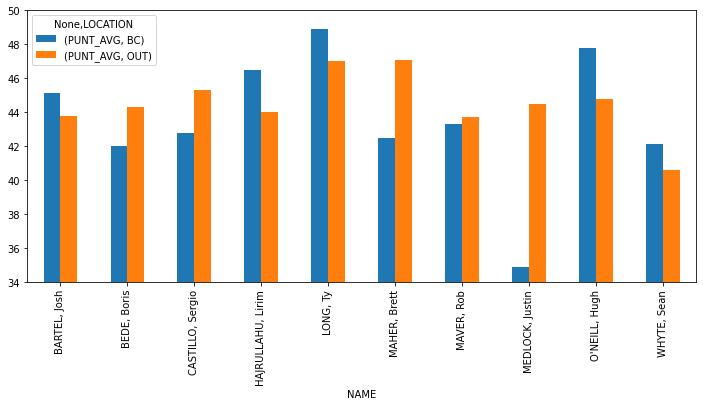

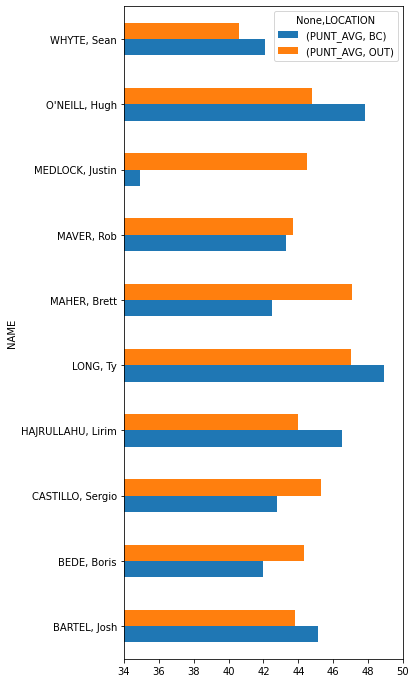

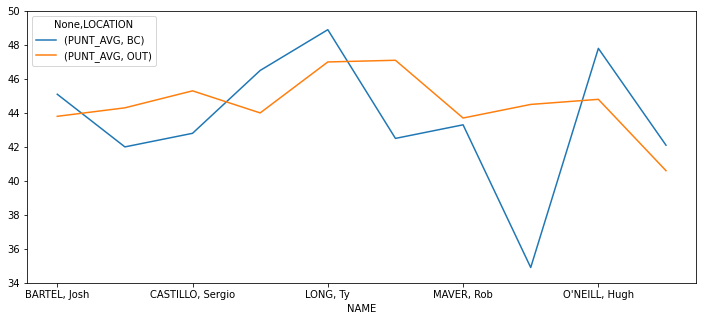

In [309]:
test = df_home_away_w_outdoor[['PUNT_AVG']]
# test.loc[2017, :].loc[:, 'BC'].plot.bar(ylim=[30,60], figsize=(12,5))
test2 = df_away_games_only
#plot 2017 BC vs Outdoors averages
test.loc[2017, :].iloc[: , [0,-1]].plot.bar(ylim=[34,50], figsize=(12,5))
test.loc[2017, :].iloc[: , [0,-1]].plot.barh(xlim=[34,50], figsize=(5,12))
test.loc[2017, :].iloc[: , [0,-1]].plot (ylim=[34,50], figsize=(12,5))

#plot 2017 BC vs Outdoors averages
# test.loc[2018, :].iloc[: , [0,-1]].plot.bar(ylim=[34,55], figsize=(12,5))

#plot 2017 BC vs Outdoors averages
# test.loc[2019, :].iloc[: , [0,-1]].plot.bar(ylim=[34,55], figsize=(12,5))



In [308]:
test.head()

PUNT_AVG                                            \
LOCATION                     BC   CGY   EDM   HAM   MTL   OTT   SSK   TOR   
YEAR NAME                                                                   
2017 BARTEL, Josh          45.1  43.3  44.8  40.2  40.7  46.5  44.5  48.6   
     BEDE, Boris           42.0  46.4  48.8   0.0  43.0  46.5   0.0  46.5   
     CASTILLO, Sergio      42.8  47.1  47.0  45.4   0.0  42.0  45.3  42.8   
     HAJRULLAHU, Lirim     46.5  49.2  36.8  41.9  40.2  45.4  40.0  43.9   
     LONG, Ty              48.9  54.4  49.4  43.0  50.3  46.0  46.8  40.9   

                                    
LOCATION                 WPG   OUT  
YEAR NAME                           
2017 BARTEL, Josh       40.6  43.8  
     BEDE, Boris        43.0  44.3  
     CASTILLO, Sergio    0.0  45.3  
     HAJRULLAHU, Lirim  51.3  44.0  
     LONG, Ty           46.0  47.0

All I really care about is the difference and which is greater and by how much so maybe some sort of calculation for that and plot the difference?

Scatter plot of 

Could put all locations on the bottom, including outdoors then add a dot for each average
